In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
def beta_opt(k,kappa, c, T, n):
    return max(9*kappa, 12*(c*kappa)**2*max(np.log(3), np.log(1.0 + T/((k*kappa)**2))) +3*kappa*(1.0+(c**2)/n))

In [70]:
T = 2000
mu = 1.0
L = 3.0 #1.0
kappa = L/mu

d = 3
n = 20 #20
plot_every = 100
x0 = 5.0

A = torch.diag(torch.tensor((np.arange(1,d+1)).astype(np.float32)))
print(f"A:{A}")
c = 1.0 #np.sqrt(2)
sigma = 1e-5 #1e-4

A:tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 3.]])


In [71]:
beta = np.ceil(beta_opt(k=n,kappa=kappa, c=c, T=T, n=n))
print(beta)

129.0


In [72]:
def noisy_loss(x, A, c = 0.0, sigma = 0.0):
    z1 = torch.randn_like(x)
    if A is None:
        output = 0.5*x*x*(1 + c*z1)
    else:
        output = 0.5*x*torch.matmul(A,x)*(1 + c*z1)
    z2 = torch.randn_like(x)
    output += sigma*z2*x
    return torch.sum(output, 0)

In [73]:
with torch.no_grad():
    loss_0 = noisy_loss(x0*torch.ones((d,1)), A=None, c = 0, sigma = 0).item()
    print(loss_0)

37.5


## One worker test

In [74]:
x = torch.tensor(x0*np.ones((d,1), dtype=np.float32),requires_grad = True)

optimizer = optim.SGD([x], lr=1.0)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 3.0/(mu*(t+beta)), last_epoch=-1)

avg_loss = 0.0
avg_losses = [loss_0]
actual_losses = [loss_0]

for t in range(T):
    optimizer.zero_grad()
    loss = noisy_loss(x, A=A, c=c, sigma=sigma)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    with torch.no_grad():
        actual_loss = noisy_loss(x, A=A, c = 0, sigma = 0)
    actual_losses.append(actual_loss)
    avg_loss += actual_loss
    
    if t%plot_every == plot_every-1:
        avg_loss /= plot_every
        avg_losses.append(avg_loss)
        avg_loss = 0.0
        
print('loss: %.5f' %  (actual_loss))

loss: 0.00000


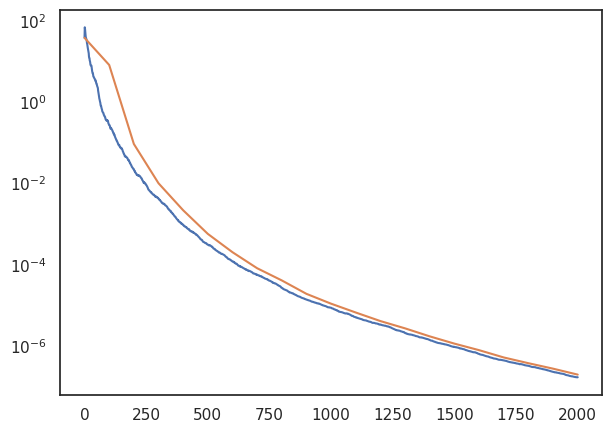

In [75]:
plt.plot(actual_losses)
plt.plot(np.arange(len(avg_losses))*plot_every, avg_losses, '-')

plt.yscale('log')
# plt.ylim([1e-5,2])
plt.show()

In [87]:
plot_labels = {0:r'Synchronous SGD', 1:r'[Sti19]', 2:'[HKMC19]', 3:'$H_i = a(i+1)$ [This Paper]', 4: r'$H = T/n$', 5:r'$H=T$ (OSA)'}

def get_comms(n, method = 5, T = 1000):
    if method == 0:
        comms = np.arange(T+1)
        print('synchronous')
        
    elif method == 1:
        H = int(np.sqrt(T/(n+0)))
        comms = [H*t for t in range(int(T/H + 1))]
        print('H=%d' %H)
        plot_labels[method] = r'$H=%d$ [Sti19]' %H

    elif method == 2:
        H = int(((T**2)/n)**(1./3))
        comms = [H*t for t in range(int(T/H + 1))]
        print('H=%d' %H)
        plot_labels[method] = r'$H=%d$ [HKMC19]' %H
        
    elif method == 3:
        # This Paper
        k = n #int(np.ceil(np.log(T)))
        a = int(np.ceil(2*T/(k**2)))
        print('k=%d, a=%d'%(k,a))
        plot_labels[method] = r'$H_i=%d(i+1)$ (This Paper)' % a
        comms = []
        for i in range(k):
            comm = a*i*(i+1)/2
            if comm <= T:
                comms.append(comm)

    elif method == 4:
        H = np.ceil(T/n)
        comms = [H*t for t in range(int(T/H + 1))]
        print('H=%d' %H)
        plot_labels[method] = r'$H=%d~(T/n)$' %H

    elif method == 5:
        H = T+0
        comms = [0,T]
        print(r'H=T (OSA)')

    if comms[-1] != T:
        comms.append(T)
        
    comms = np.array(comms, dtype = int)
#     print(comms)
    return comms

In [77]:
def train_dist(comms, T, n, reps = 1, plot_every = 100, print_every = 10):
    # losses_avg_dist = np.zeros(51)
    comm_error_avg = np.zeros(len(comms))
    iter_error_avg = np.zeros(np.ceil(T/plot_every + 1).astype(int))
    iter_error2_avg = np.zeros(np.ceil(T/plot_every + 1).astype(int))
#     running_error_avg = np.zeros(np.ceil(T/plot_every + 1).astype(int))
    
    
    for rep in range(reps):        
        avg_loss = 0.0
        avg_losses = [loss_0]
#         actual_losses = [loss_0]

        X = torch.tensor(x0*np.ones((d,n), dtype=np.float32),requires_grad = True)
        optimizer = optim.SGD([X], lr=1.0)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: 3.0/(mu*(t+beta)), last_epoch=-1)
        
        comm_error = [loss_0]
        iter_error = [loss_0]
        for t in range(T):
            optimizer.zero_grad()
            loss = noisy_loss(X, A=A, c=c, sigma=sigma).sum()

            loss.backward()
            optimizer.step()
            scheduler.step()
            
#             with torch.no_grad():
#                 actual_loss = noisy_loss(X.data.mean(dim=1).unsqueeze(1), A=A, c = 0, sigma = 0).item()
# #             actual_losses.append(actual_loss)
#             avg_loss += actual_loss/plot_every

            if (t+1) in comms or t == T-1: # calculating the average of workers' parameters
                x_avg = torch.mean(X.data, dim = 1).unsqueeze(1)
                X.data = torch.ones_like(X)*x_avg
                
                with torch.no_grad():
                    actual_loss = noisy_loss(x_avg, A=A, c = 0, sigma = 0)
                
                comm_error.append(actual_loss)


            if t % plot_every == plot_every-1  or t == T-1:
                # calculating the average of workers' parameters
# #                 avg_loss /= plot_every
#                 avg_losses.append(avg_loss)
#                 avg_loss = 0.0
                
                x_avg = torch.mean(X.data, dim = 1).unsqueeze(1)
                with torch.no_grad():
                    actual_loss = noisy_loss(x_avg, A=A, c = 0, sigma = 0)
                iter_error.append(actual_loss)


        comm_error_avg += np.array(comm_error)
        iter_error_avg += np.array(iter_error)
        iter_error2_avg += np.array(iter_error)**2
#         running_error_avg += np.array(avg_losses)
        
        if rep % print_every == print_every - 1:
            print('Simulation: %d/%d'%(rep+1,reps))

    comm_error_avg /= reps
    iter_error_avg /= reps
    iter_error2_avg /= reps
#     running_error_avg /= reps
    
    return comm_error_avg, iter_error_avg, iter_error2_avg, # running_error_avg

method 0
synchronous
# of comms: 2000
Simulation: 100/200
Simulation: 200/200
------
method 3
k=20, a=10
# of comms: 20
Simulation: 100/200
Simulation: 200/200
------


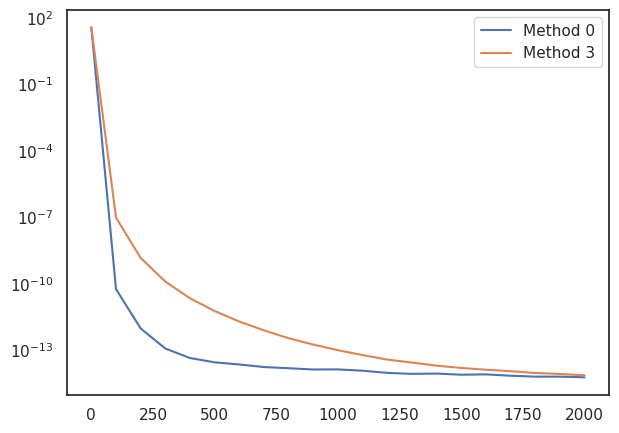

In [78]:
reps_dict = {0:500, 1:500, 2:500, 3:500, 4:500, 5:500}
# running_dict = {}
iter_avg_dict = {}
iter_std_dict = {}
comm_dict = {}
beta = 1
# print_every = reps/2

for method in [0,3]:
    print('method %d'% method)
    comms = get_comms(n, method, T)
    print('# of comms: %d' % (len(comms)-1))
    
#     reps = reps_dict[method]
    reps = 200
    print_every = reps/2
    
    comm_error_avg, iter_error_avg, iter_error2_avg = train_dist(comms, T, n, reps, plot_every, print_every)
    
    iter_std = np.sqrt(iter_error2_avg - iter_error_avg**2)
    
#     running_dict[method] = running_error_avg
    iter_avg_dict[method] = iter_error_avg
    iter_std_dict[method] = iter_std
    comm_dict[method] = comm_error_avg
    
#     plt.fill_between(plot_every*np.arange(len(iter_error_avg)), iter_error_avg - iter_std, iter_error_avg + iter_std, alpha = 0.3)
    plt.plot(plot_every*np.arange(len(iter_error_avg)), iter_error_avg, '-', label = 'Method %d' % method)
    print('------')
    
plt.yscale('log')
plt.legend()
plt.show()

In [502]:
# Save results to a file
file_name = 'skewed_c{:.1f}_d{}_n{}_T{}_{}x.pkl'.format(c,d,n,T,reps)
with open( file_name, 'wb') as f:
    pickle.dump({'iter_avg_dict': iter_avg_dict, 'iter_std_dict': iter_std_dict, 'comm_dict': comm_dict, 'reps': reps, 'plot_every': plot_every, 'T': T, 'plot_labels': plot_labels, 'n': n}, f)
    f.close()
print('file saved: ' + file_name)

file saved: skewed_c1.0_d3_n20_T1000_500x.pkl


In [19]:
# loadind data
file_name = 'c1sigma1e-5T1000n20_500x/skewed_c1.0_d3_n20_T1000_500x.pkl'
data = pickle.load(open(file_name, 'rb'))
print(data.keys())

iter_avg_dict = data['iter_avg_dict']
comm_dict = data['comm_dict']
iter_std_dict = data['iter_std_dict']

plot_every = data['plot_every']
plot_labels = data['plot_labels']
reps = data['reps']
del data

dict_keys(['iter_avg_dict', 'iter_std_dict', 'comm_dict', 'reps', 'plot_every', 'T', 'plot_labels', 'n'])


## Plotting the results

In [79]:
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(7,5)}, 
    style="white" # nicer layout
)

In [92]:
# Combining the outputs in one dataframe for Seaborn
errors = []
txerrors = []
running_errors = []
errors_std = []
txerrors_std = []
iterations = []
methods = []
for m in [3,0]: #,1,2,4,5]:
    errors = np.append(errors, iter_avg_dict[m])
    txerrors = np.append(txerrors, iter_avg_dict[m]*(plot_every*np.arange(len(iter_avg_dict[m]))+1))
#     running_errors = np.append(running_errors, running_dict[m] )
#     errors_std = np.append(errors_std, iter_std_dict[m])
#     txerrors_std = np.append(txerrors_std, iter_std_dict[m]*(plot_every*np.arange(len(iter_std_dict[m]))))
    iterations = np.append(iterations, plot_every*np.arange(len(iter_avg_dict[m])))
    methods += [plot_labels[m]]*len(iter_avg_dict[m])

iter_dict_comb = {'iter': iterations, 'error': errors, 'txerror': txerrors, 'method': methods} #'std': errors_std,  'txstd': txerrors_std, }
iter_df = pd.DataFrame(iter_dict_comb)
iter_df.head()

,iter,error,txerror,method
0,0.0,3.750000e+01,3.750000e+01,$H_i=10(i+1)$ (This Paper)
1,100.0,9.741550e-08,9.838965e-06,$H_i=10(i+1)$ (This Paper)
2,200.0,1.466235e-09,2.947133e-07,$H_i=10(i+1)$ (This Paper)
3,300.0,1.258268e-10,3.787385e-08,$H_i=10(i+1)$ (This Paper)
4,400.0,2.213353e-11,8.875546e-09,$H_i=10(i+1)$ (This Paper)


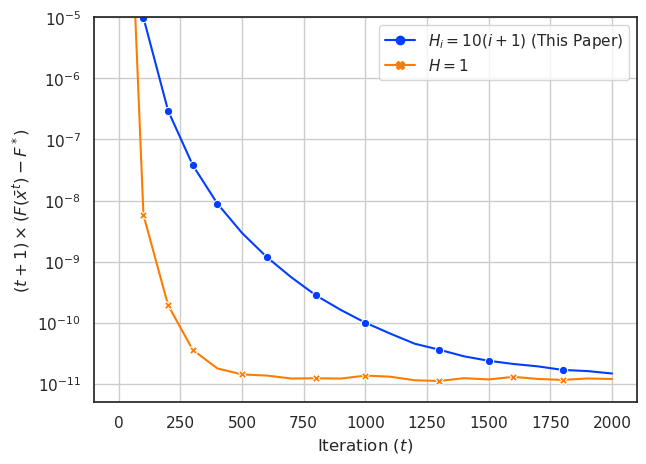

In [82]:
ax = sns.lineplot(x = 'iter', y= 'txerror', data = iter_df.loc[iter_df['method'].isin([plot_labels[i] for i in [0,3]])],
                  hue = 'method', palette = 'bright', style = 'method',  markers = True, dashes = False, markevery=.1)

# plt.gca().set_prop_cycle(None)
# for m in [1,2,3,4]:
#     iter_std = iter_std_dict[m]
#     plt.fill_between(
#         plot_every*np.arange(len(iter_std)),
#         (plot_every*np.arange(len(iter_avg_dict[m]))+1)*(iter_avg_dict[m]),
#         (plot_every*np.arange(len(iter_avg_dict[m]))+1)*(iter_avg_dict[m] + iter_std),
#         alpha=0.2)

plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.xlabel(r'Iteration $(t)$')
# plt.ylabel(r'$F(\bar x^t) - F^*$')
plt.ylabel(r'$(t+1)\times(F(\bar x^t) - F^*)$')
plt.ylim([5e-12,1e-5])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
# plt.savefig('txiteration_c{}_d{}_n{}_T{}_{}x_skewed.png'.format(c,d,n,T,reps), dpi=240, transparent=False, bbox_inches='tight')
plt.show()

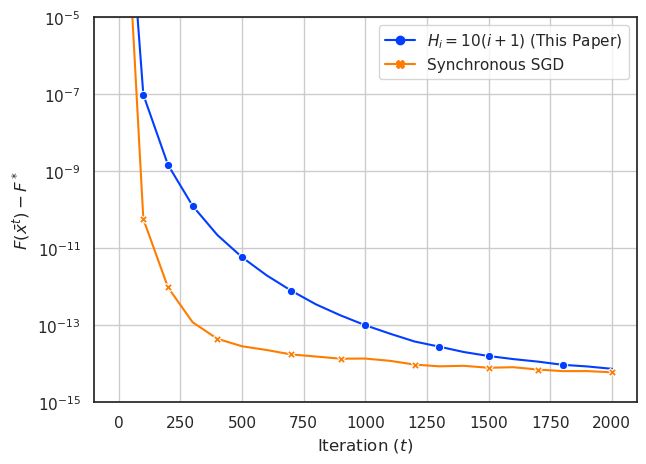

In [94]:
ax = sns.lineplot(x = 'iter', y= 'error', data = iter_df.loc[iter_df['method'].isin([plot_labels[i] for i in [0,3]])],
                  hue = 'method', palette = 'bright', style = 'method',  markers = True, dashes = False, markevery=.1)

# plt.gca().set_prop_cycle(None)
# for m in [1,2,3,4]:
#     iter_std = iter_std_dict[m]
#     plt.fill_between(
#         plot_every*np.arange(len(iter_std)),
#         (iter_avg_dict[m]),
#         (iter_avg_dict[m] + iter_std),
#         alpha=0.2)

plt.yscale('log')
# plt.xscale('log')
plt.grid()
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$F(\bar x^t) - F^*$')
# plt.ylabel(r'$(t+1)\times(F(\bar x^t) - F^*)$')

# plt.xlim([0,1000])
plt.ylim([1e-15,1e-5])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

# plt.savefig('iteration_c{}_d{}_n{}_T{}_{}x_skewed.png'.format(c,d,n,T,reps), dpi=240, transparent=False, bbox_inches='tight')
plt.savefig('asymptotic.png'.format(c,d,n,T,reps), dpi=240, transparent=False, bbox_inches='tight')
plt.show()

In [58]:
# Combining the outputs in one dataframe for Seaborn
errors = []
comms = []
methods = []
for m in [3,0,1,2,4,5]:
    errors = np.append(errors, comm_dict[m])
    comms = np.append(comms, np.arange(len(comm_dict[m]))+1)
    methods += [plot_labels[m]]*len(comm_dict[m])

comm_dict_comb = {'comm+1': comms, 'error': errors, 'method': methods}
comm_df = pd.DataFrame(comm_dict_comb)
comm_df.head()

,comm+1,error,method
0,1.0,3.750000e+01,$H_i=5(i+1)$ (This Paper)
1,2.0,2.793750e+06,$H_i=5(i+1)$ (This Paper)
2,3.0,6.203159e+04,$H_i=5(i+1)$ (This Paper)
3,4.0,1.354757e-01,$H_i=5(i+1)$ (This Paper)
4,5.0,8.720795e-06,$H_i=5(i+1)$ (This Paper)


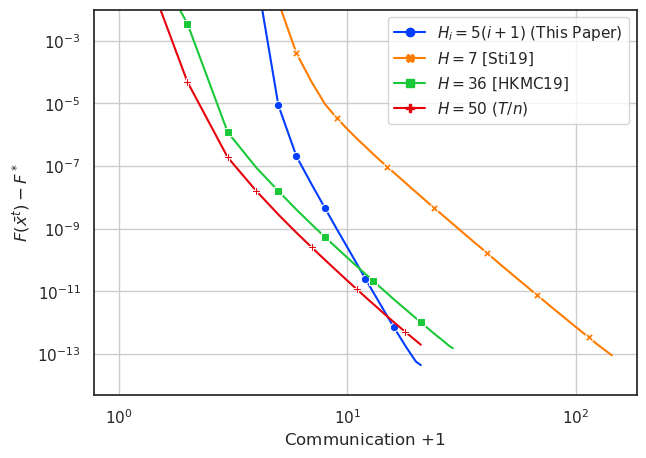

In [68]:
ax = sns.lineplot(x = 'comm+1', y= 'error', data = comm_df.loc[comm_df['method'].isin([plot_labels[i] for i in [1,2,3,4]])],
                  hue = 'method', palette = 'bright', style = 'method',  markers = True, dashes = False, markevery=.1)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel(r'Communication $+1$')
plt.ylabel(r'$F(\bar x^t) - F^*$')
plt.ylim([5e-15,1e-2])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
# plt.savefig('communication_c{}_d{}_n{}_T{}_{}x_skewed.png'.format(c,d,n,T,reps), dpi=240, transparent=False, bbox_inches='tight')
plt.show()

#### Speed-up Curve

n 1
k=1, a=1000
# of comms: 1
Simulation: 250/500
Simulation: 500/500
------
n 2
k=2, a=250
# of comms: 2
Simulation: 250/500
Simulation: 500/500
------
n 4
k=4, a=63
# of comms: 4
Simulation: 250/500
Simulation: 500/500
------
n 8
k=8, a=16
# of comms: 8
Simulation: 250/500
Simulation: 500/500
------
n 16
k=16, a=4
# of comms: 16
Simulation: 250/500
Simulation: 500/500
------
n 32
k=32, a=1
# of comms: 32
Simulation: 250/500
Simulation: 500/500
------


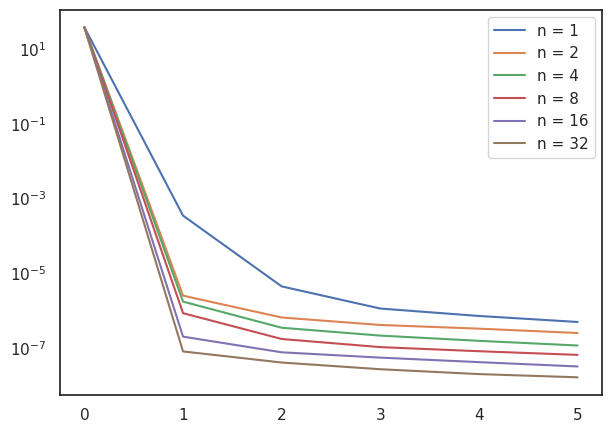

In [522]:
T=500 #4000
sigma = 1e-2
# plot_every = 100
# reps = 500
# running_dict = {}

iter_avg_dict = {}
iter_std_dict = {}
comm_dict = {}
beta = 1
# print_every = reps/2
method = 3

for n in [1, 2, 4, 8, 16, 32]:
    print('n %d'% n)
    comms = get_comms(n, method, T)
    
    k=len(comms)-1
    print('# of comms: %d' % (k))
    
    reps = 500 #int(512/n)
    print_every = reps/2
    comm_error_avg, iter_error_avg, iter_error2_avg = train_dist(comms, T, n, reps, plot_every, print_every)
    
    iter_std = np.sqrt(iter_error2_avg - iter_error_avg**2)/np.sqrt(reps)
    
    iter_avg_dict[n] = iter_error_avg
    iter_std_dict[n] = iter_std
    comm_dict[n] = comm_error_avg
#     running_dict[n] = running_error_avg
    plt.plot(iter_error_avg, '-', label = 'n = %d' % n)
    print('------')
    
plt.yscale('log')
plt.legend()
plt.show()

In [523]:
# Combining the outputs in one dataframe for Seaborn
errors = []
iters = []
methods = []
for n in [1,2,4,8,16,32]:
    errors = np.append(errors, iter_avg_dict[n])
    iters = np.append(iters, plot_every*np.arange(len(iter_avg_dict[n]))+1)
    methods += [r'$n = %d$'%n]*len(iter_avg_dict[n])


iter_dict_comb = {'iter': iters, 'error': errors, 'method': methods}
iter_df = pd.DataFrame(iter_dict_comb)
iter_df.head()

,iter,error,method
0,1.0,3.750000e+01,$n = 1$
1,101.0,3.427684e-04,$n = 1$
2,201.0,4.383998e-06,$n = 1$
3,301.0,1.120411e-06,$n = 1$
4,401.0,7.091003e-07,$n = 1$


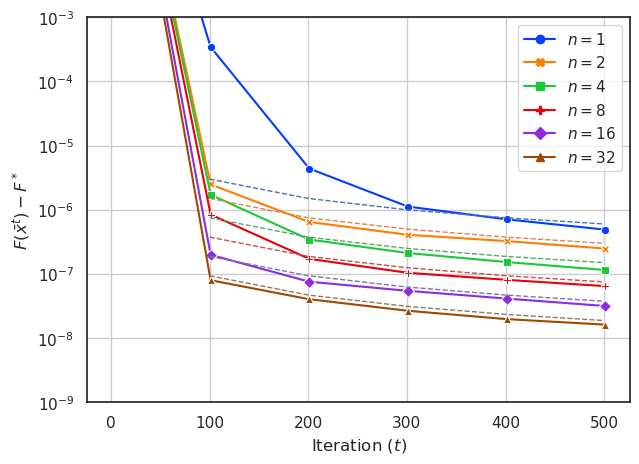

In [527]:
ax = sns.lineplot(x = 'iter', y= 'error', hue = 'method', palette = 'bright', style = 'method',  markers = True, dashes = False, data = iter_df,  markevery=.1)

plt.gca().set_prop_cycle(None)
for n in iter_avg_dict.keys():
    plt.plot(plot_every*np.arange(1,T/plot_every+1), d*(sigma**2)/(n*(plot_every*np.arange(1,T/plot_every+1))), '--', linewidth = 1)
    
plt.yscale('log')
plt.ylim([1e-9,1e-3])
plt.grid()
plt.xlabel(r'Iteration $(t)$')
plt.ylabel(r'$F(\bar x^t) - F^*$')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

file_name = 'skewed_c{:.2f}_d{}_sigma{}_T{}_{}x_speedup.png'.format(c,d,sigma,T,reps)
plt.savefig(file_name, dpi=240, transparent=False, bbox_inches='tight')